In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

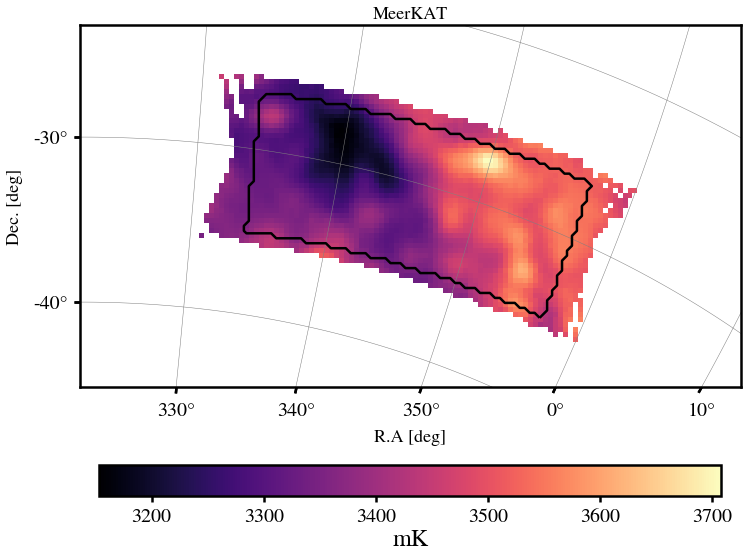

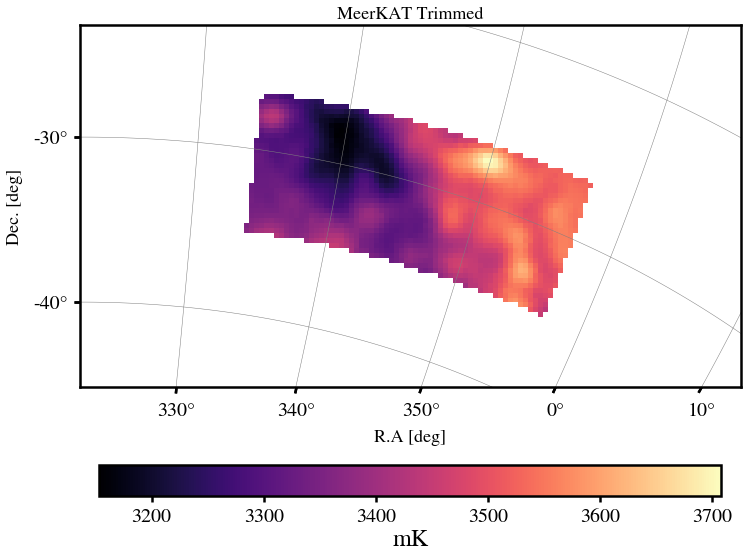

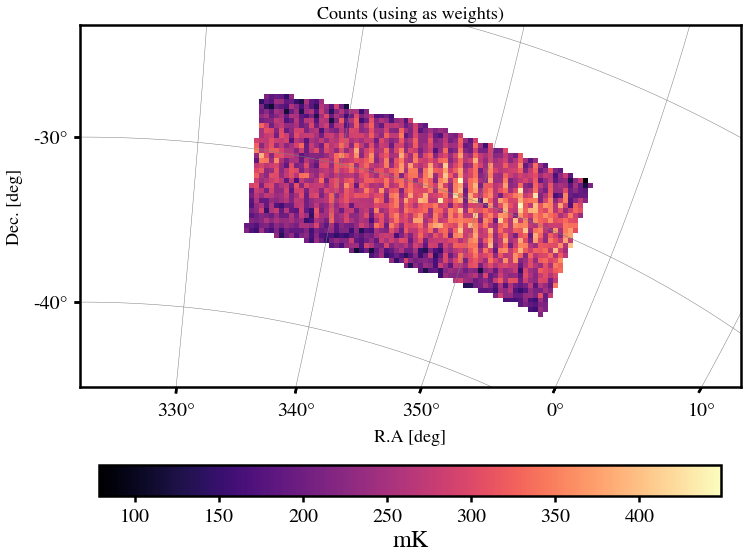

In [3]:
# Read-in level6 MeerKAT data:
#filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
#map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # KiDS bias (currently same as GAMA - tune to improve!)
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
### Before trimming map, show contour of trimmed area:
MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
plot.Map(MKmap_untrim,W=W_HI_untrim,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT',cbarshrink=0.6)
MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)
contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='black')
plt.show()

### Use counts map as weights:
w_HI = counts_HI # Not factorised along LoS so will add rank if used in foreground cleaning in current form

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Trimmed',cbarshrink=0.6)
plot.Map(counts_HI,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Counts (using as weights)',cbarshrink=0.6)
plt.show()

### KiDS galaxies

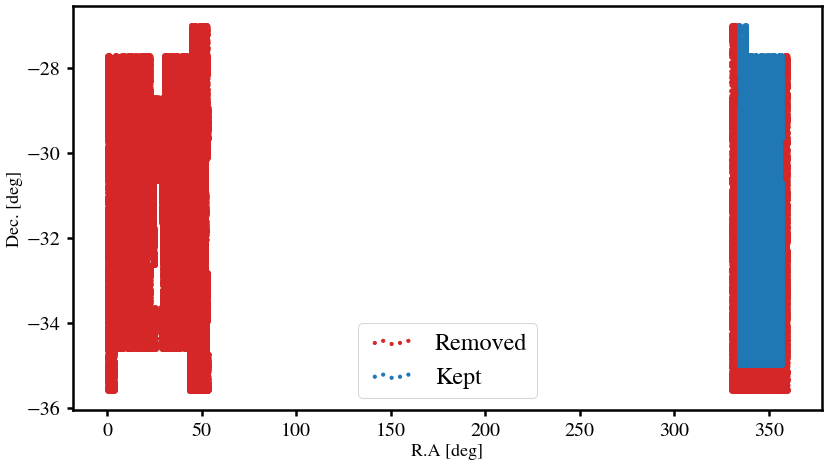

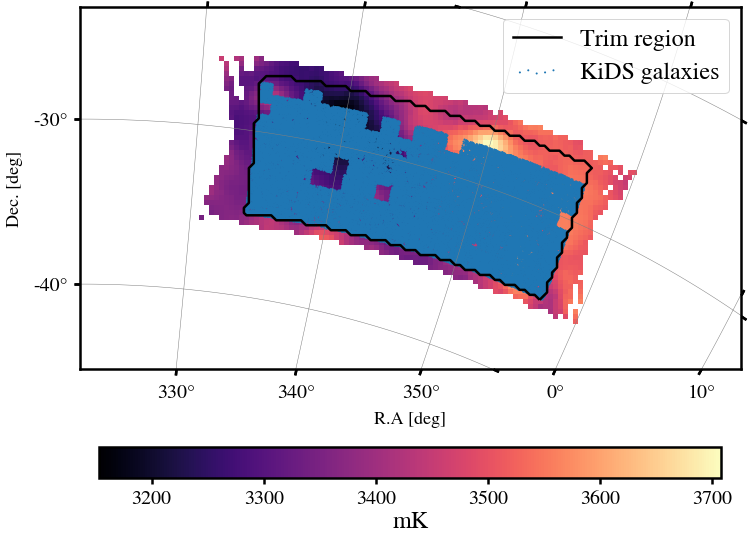

In [7]:
# Read-in KiDS galaxies:
ra_g,dec_g,z_g = np.load('/idia/projects/hi_im/KiDS_DR4/SOM-gold_2021footprint_0.4z_ph0.46.npy')

### Remove galaxies outside bulk MeerKAT trimmed footprint:
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
KiDScutmask = (ra_g>raminMK) & (ra_g<ramaxMK) & (dec_g>decminMK) & (dec_g<decmaxMK)
plt.figure(figsize=(13,7))
plt.scatter(ra_g[~KiDScutmask],dec_g[~KiDScutmask],s=10,label='Removed',color='tab:red')
ra_g,dec_g,z_g = ra_g[KiDScutmask],dec_g[KiDScutmask],z_g[KiDScutmask]
plt.scatter(ra_g,dec_g,s=10,label='Kept',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

### For null testing:
#np.random.shuffle(z_g)

### Plot MK map with overlaid KiDS galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(MKmap_untrim,2)
img[W_HI_untrim[:,:,0]==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='black')
plt.plot(np.nan,np.nan,color='black',label='Trim region') # dummy line for contour legend label
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label='KiDS galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

### Cartesian regridding:

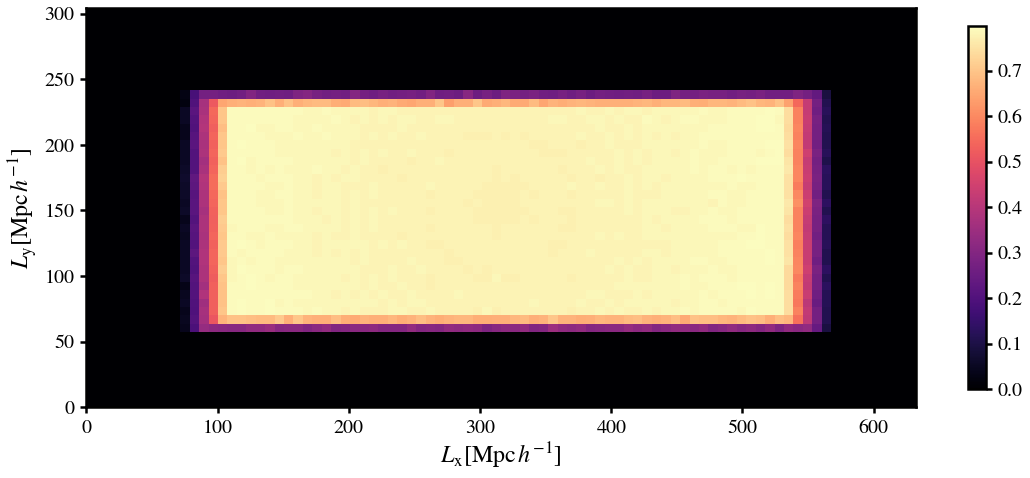

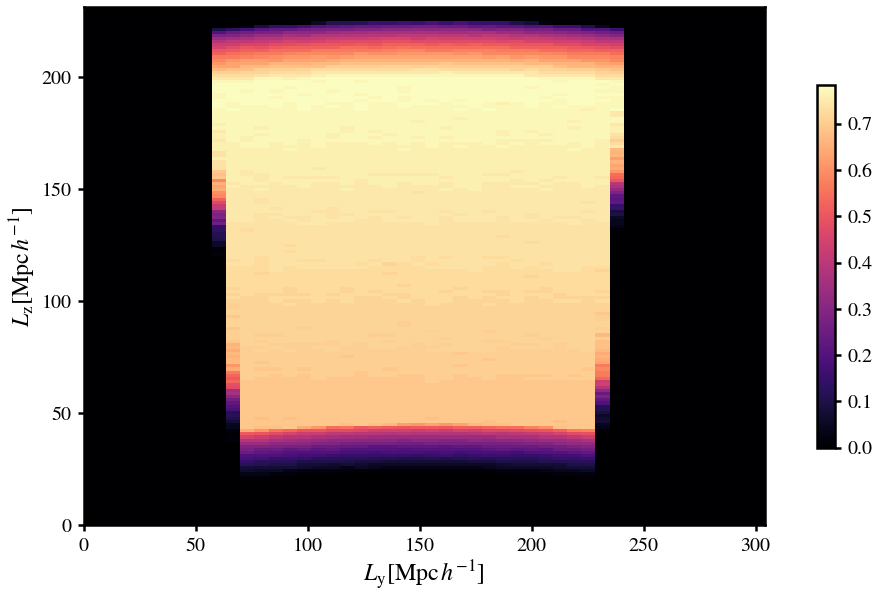

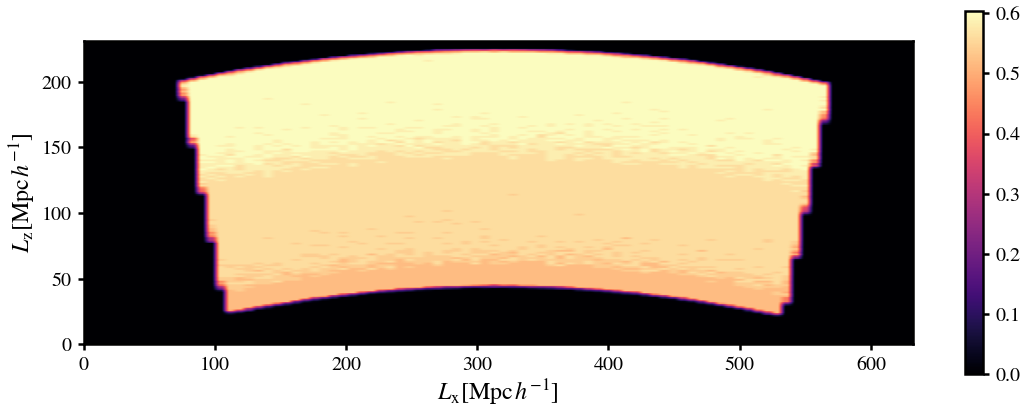

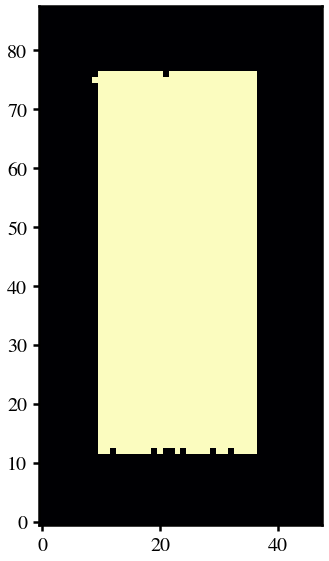

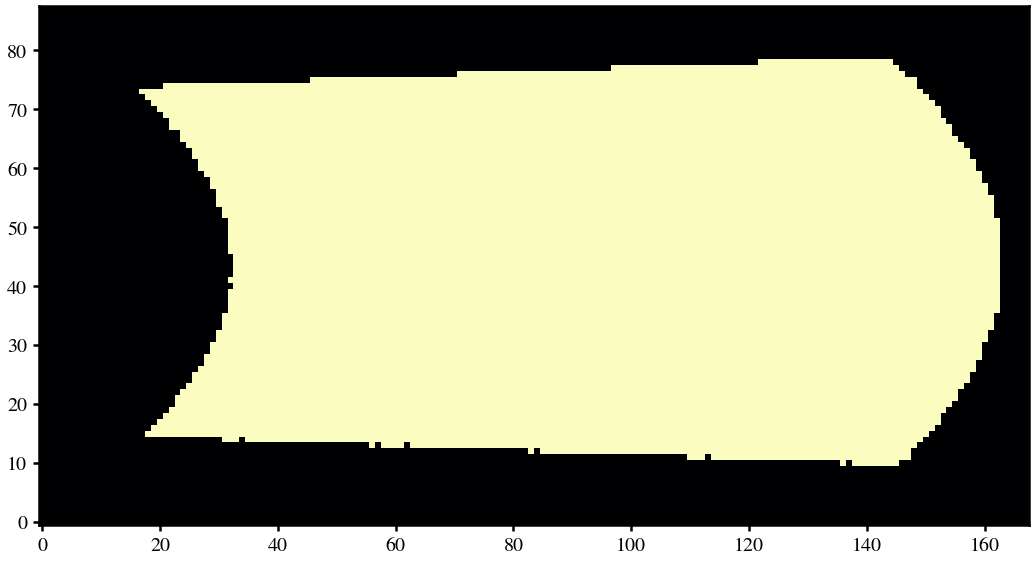

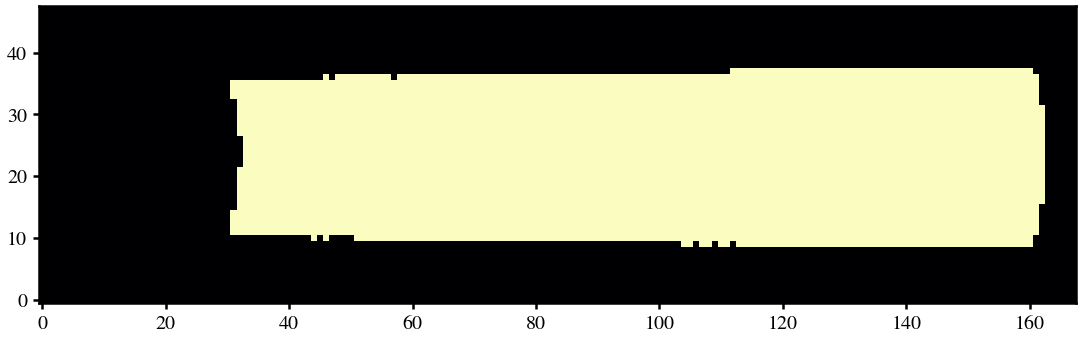

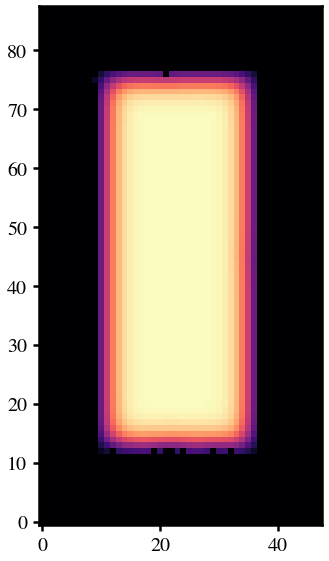

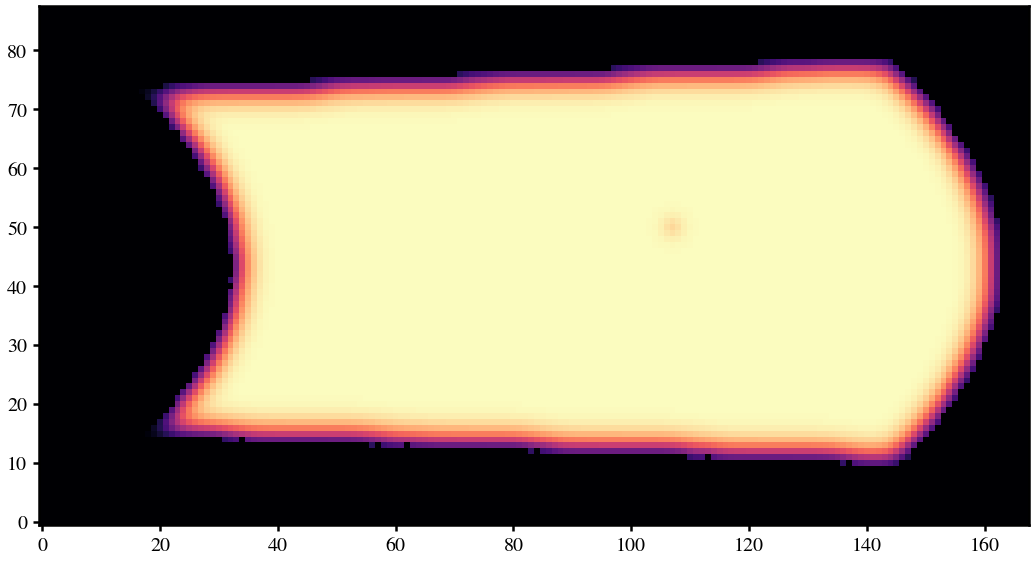

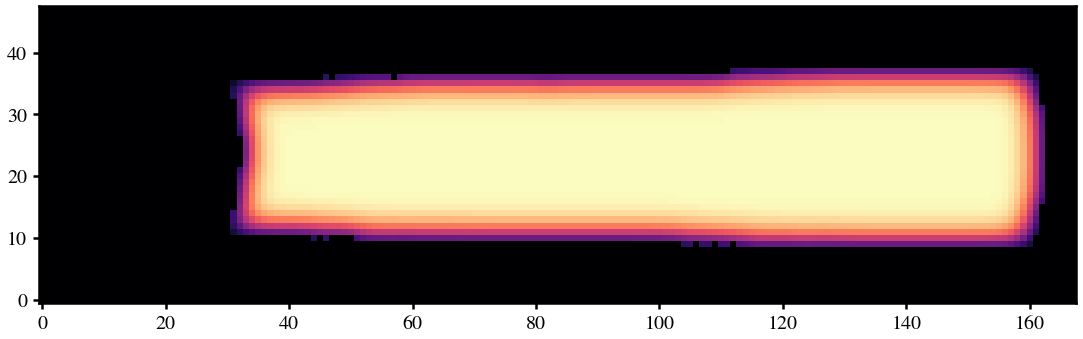

In [8]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
window = 'ngp'
compensate = True
interlace = True
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
nxmap,nymap,nzmap = np.shape(MKmap)
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),int(nzmap/cell2vox_factor)
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W_HI) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

# Grid KiDS galaxies straight to Cartesian field:
xp,yp,zp = grid.SkyCoordtoCartesian(ra_g,dec_g,z_g,ramean_arr=ra,decmean_arr=dec,doTile=False)
n_g_rg,W_fft,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window=window,compensate=compensate,interlace=interlace,verbose=False)

# Grid uncut pixels to obtain binary masks in Cartesian space:
######################################################################
##### UPDATE THIS WITH KIDS SURVEY SELECTION FUNCTION ##########
######################################################################
ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
MKcutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_HI_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
'''
KiDScutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[KiDScutmask],dec_p[KiDScutmask],HItools.Freq2Red(nu_p[KiDScutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W01_g_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)
'''
W01_g_rg = np.copy(W01_HI_rg)

### Show binary window averaged along each dimension for sanity check:
plt.imshow(np.mean(W01_HI_rg,2).T,extent=[0,lx,0,ly])
plt.xlabel(r'$L_{\rm x} [{\rm Mpc}\,h^{-1}$]')
plt.ylabel(r'$L_{\rm y} [{\rm Mpc}\,h^{-1}$]')
plt.colorbar(shrink=0.7)
plt.show()
plt.imshow(np.mean(W01_HI_rg,0).T,extent=[0,ly,0,lz])
plt.xlabel(r'$L_{\rm y} [{\rm Mpc}\,h^{-1}$]')
plt.ylabel(r'$L_{\rm z} [{\rm Mpc}\,h^{-1}$]')
plt.colorbar(shrink=0.7)
plt.show()
plt.imshow(np.mean(W01_HI_rg,1).T,extent=[0,lx,0,lz])
plt.xlabel(r'$L_{\rm x} [{\rm Mpc}\,h^{-1}$]')
plt.ylabel(r'$L_{\rm z} [{\rm Mpc}\,h^{-1}$]')
plt.colorbar(shrink=0.7)
plt.show()

# Regrid IM weights to Cartesian field (regrid HI IM map later after foreground cleaning):
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w_HI,W=W_HI,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_HI_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

# Create tapering to apply to Cartesian fields
# - needs to taper a conical footprint so currently using a technique that Gaussian smooths inwards from the empty edges:
doTaper = True # Implement apodisation window functions to apply to maps and weights to taper edges
if doTaper==True:
    # Gaussian smoothing from empty edges:
    taper_HI = np.copy(W01_HI_rg)
    taper_g = np.copy(W01_g_rg)
    from scipy.ndimage import gaussian_filter
    for i in range(8):
        taper_HI = gaussian_filter(taper_HI, sigma=1, mode='reflect')
        taper_HI[W01_HI_rg==0] = 0
        taper_g = gaussian_filter(taper_g, sigma=1, mode='reflect')
        taper_g[W01_g_rg==0] = 0
if doTaper==False: taper_HI,taper_g = 1,1

### Plots to check tapering of conical footprint is working:
taper_plot = np.copy(taper_HI)
no_taper_plot = np.copy(W01_HI_rg)
#taper_plot = np.copy(taper_g)
#no_taper_plot = np.copy(W01_g_rg)
plt.imshow(no_taper_plot[:,:,int(nz_rg/2)])
plt.figure()
plt.imshow(no_taper_plot[:,int(ny_rg/2),:])
plt.figure()
plt.imshow(no_taper_plot[int(nx_rg/2),:,:])
plt.figure()
plt.imshow(taper_plot[:,:,int(nz_rg/2)])
plt.figure()
plt.imshow(taper_plot[:,int(ny_rg/2),:])
plt.figure()
plt.imshow(taper_plot[int(nx_rg/2),:,:])
plt.show()

# Multiply tapering window by all galaxy fields that undergo Fourier transforms
n_g_rg = taper_g*n_g_rg
W01_g_rg = taper_g*W01_g_rg
w_g_rg = np.ones(np.shape(n_g_rg))
w_g_rg = taper_g*w_g_rg
# Multiply tapering window by HI weights and window (final HI IM field is tapered later after foreground cleaning)
w_HI_rg,W01_HI_rg = taper_HI*w_HI_rg,taper_HI*W01_HI_rg

### Power spectrum measurement and modelling:

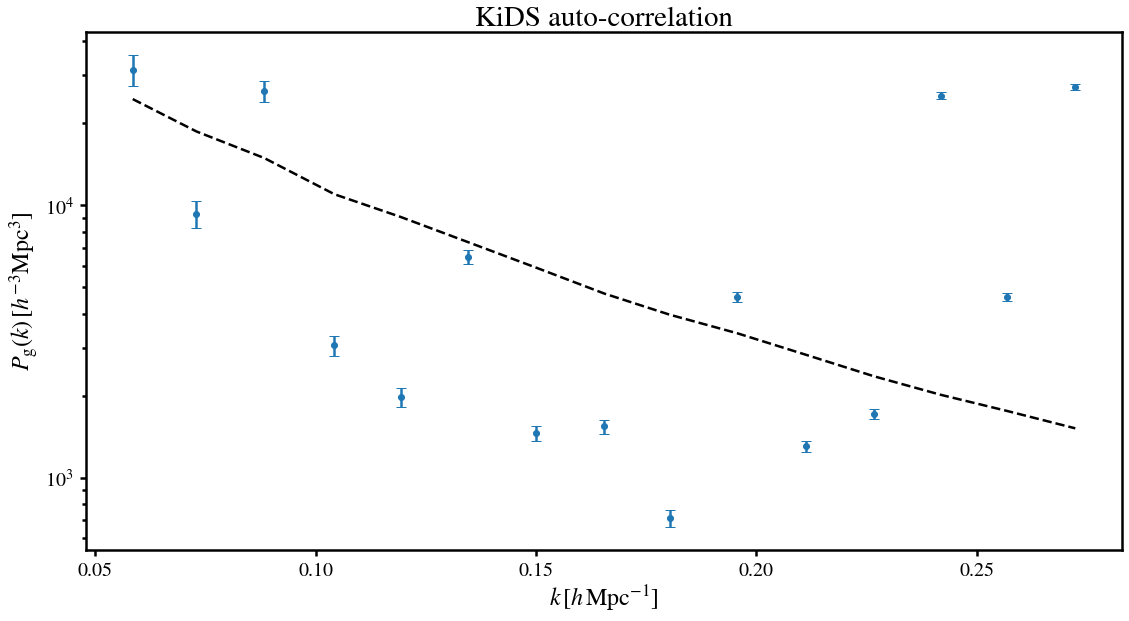

0
1
2
3
4
5


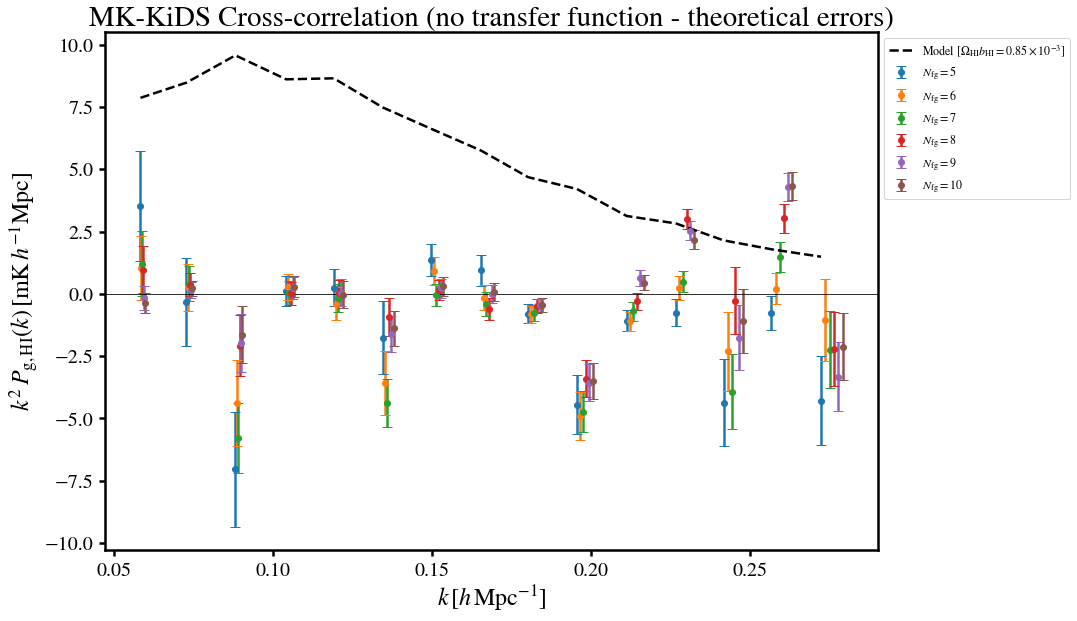

In [11]:
import foreground
import power # All power spectrum calculations performed in this script
import model
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]
kcuts = None
#kcuts = [None,0.01,0.2,None] #[kperpmin,kparamin,kperpmax,kparamax] (exclude areas of k-space from spherical average)

### KiDS Auto-power (use to constrain bias):
Pk_g,k,nmodes = power.Pk(n_g_rg,n_g_rg,dims_rg,kbins,corrtype='Galauto',w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg)
nbar = np.sum(n_g_rg)/(lx*ly*lz) # Calculate number density inside survey footprint
P_SN = np.ones(len(k))*1/nbar # approximate shot-noise for errors (already subtracted in Pk estimator)
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_g,b_g,f,sig_v,Tbar1=1,Tbar2=1,r=1,R_beam1=0,R_beam2=0,w1=w_g_rg,w2=w_g_rg,W1=W01_g_rg,W2=W01_g_rg,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
sig_g = 1/np.sqrt(nmodes)*(Pk_g+P_SN)
plt.errorbar(k,Pk_g,sig_g,ls='none',marker='o')
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.yscale('log')
plt.title('KiDS auto-correlation')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g}(k)\,[h^{-3}{\rm Mpc}^{3}]$')
plt.axhline(0,lw=0.8,color='black')
plt.show()

# Chose factorisation of P(k) in plotting:
#norm = np.ones(nkbin)
norm = k**2

#N_fgs = [5,6,7,8]
N_fgs = [5,6,7,8,9,10]
indx_choice = 2 # Make N_fg index choice to show covariance, 2D power and final error results for

### Foreground clean and measure cross power spectra:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i in range(len(N_fgs)):
    print(i)
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W_HI,w=None)
    '''
    shuffleindex = np.arange(0,nz,1)
    np.random.shuffle(shuffleindex)
    MKmap_clean = MKmap_clean[:,:,shuffleindex]
    '''
    # Regrid cleaned map to Cartesian field:
    ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W_HI,Np=Np)
    xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
    MKmap_clean_rg_i,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

    # Multiply tapering window by all cleaned map:
    MKmap_clean_rg_i = taper_HI*MKmap_clean_rg_i

    # Measure and plot power spectrum:
    Pk_HI,k,nmodes = power.Pk(MKmap_clean_rg_i,MKmap_clean_rg_i,dims_rg,kbins,corrtype='HIauto',w1=w_HI_rg,w2=w_HI_rg,W1=W01_HI_rg,W2=W01_HI_rg,kcuts=kcuts)
    Pk_X_i,k,nmodes = power.Pk(MKmap_clean_rg_i,n_g_rg,dims_rg,kbins,corrtype='Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,kcuts=kcuts)
    sig_err = 1/np.sqrt(2*nmodes) * np.sqrt( Pk_X_i**2 + Pk_HI*( Pk_g + P_SN ) ) # Error estimate
    plt.errorbar(k+(k/200*i),norm*Pk_X_i,norm*sig_err,label=r'$N_{\rm fg}=%s$'%N_fgs[i],ls='none',marker='o',color=colors[i])

    if i==indx_choice:
        Pk_X = Pk_X_i
        MKmap_clean_rg = MKmap_clean_rg_i

# Model power spectrum:
sig_v = 400
dpix = 0.3
d_c = cosmo.d_com(HItools.Freq2Red(np.min(nu)))
s_pix = d_c * np.radians(dpix)
s_para = np.mean( cosmo.d_com(HItools.Freq2Red(nu[:-1])) - cosmo.d_com(HItools.Freq2Red(nu[1:])) )
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_g,f,sig_v,Tbar1=Tbar,Tbar2=1,r=1,R_beam1=R_beam,R_beam2=0,w1=W01_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg,s_pix=s_pix,s_para=s_para,interpkbins=True,MatterRSDs=False,gridinterp=True)[0:2]
plt.plot(k,norm*pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))

if norm[0]==1.0: plt.yscale('log')
plt.legend(fontsize=12,loc='upper left',bbox_to_anchor=[1,1])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
if norm[0]==1.0: plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
else: plt.ylabel(r'$k^2\,P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-1}{\rm Mpc}]$')
plt.axhline(0,lw=0.8,color='black')
plt.subplots_adjust(right=0.75)
plt.title('MK-KiDS Cross-correlation (no transfer function - theoretical errors)')
plt.show()

### Analyse 2D Power:

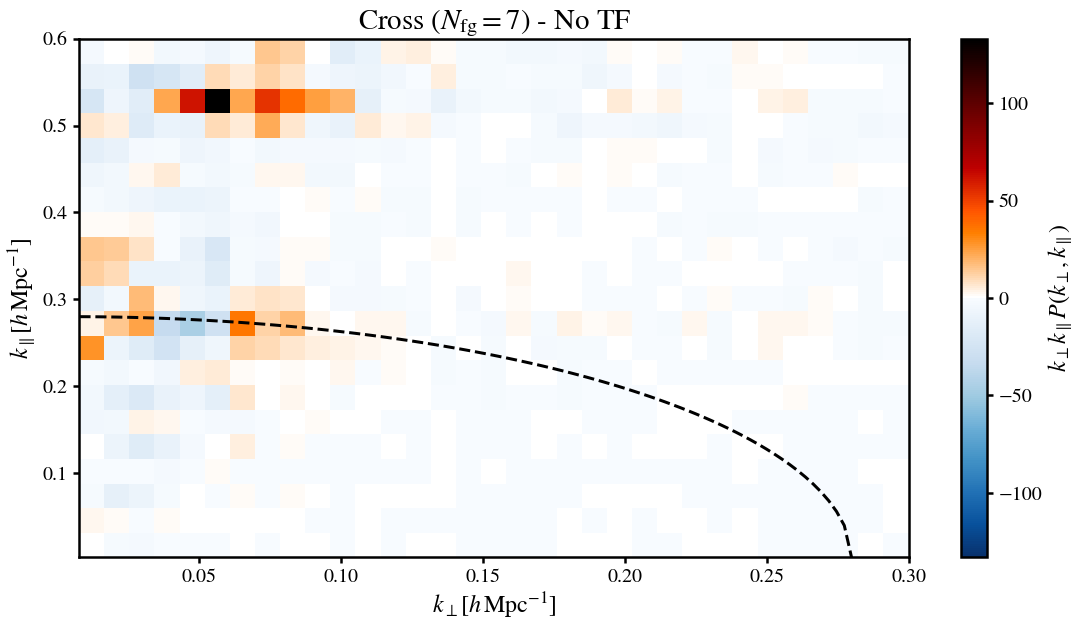

In [12]:
### Chose 2D k-bins:
kperpbins = np.linspace(0.008,0.3,34)
kparabins = np.linspace(0.003,0.6,22)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kperpgrid = np.tile(kperpcen,(len(kparacen),1))
kparagrid = np.tile(kparacen,(len(kperpcen),1))
kparagrid = np.swapaxes(kparagrid,0,1)
kgrid = kperpcen * kparacen[:,np.newaxis]

### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

Pk2D,k2d,nmodes = power.Pk2D(MKmap_clean_rg,n_g_rg,dims_rg,kperpbins,kparabins,'Cross',w1=w_HI_rg,w2=W01_g_rg,W1=W01_HI_rg,W2=W01_g_rg)

vmaxX = np.max(kgrid*Pk2D)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D,cmap=mycmap,vmin=-vmaxX,vmax=vmaxX)
### 1D k_max contour:
kperp = np.linspace(np.min(kperpbins),kmax,100)
kpara = np.linspace(np.min(kparabins),kmax,100)
kcont = np.sqrt(kmax**2 - kpara**2)
plt.plot(kperp,kcont,color='black',ls='--',lw=3)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlim(left=kperpbins[0])
plt.ylim(bottom=kparabins[0])
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'Cross ($N_{\rm fg}=%s$) - No TF'%N_fgs[indx_choice])
plt.show()